In [4]:
import copy
import datetime
from datetime import date

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib.dates import DateFormatter

# NWIS API library
import dataretrieval.nwis as nwis

# Filesystem
import sys
sys.path.append("../../")

# ML library
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from ipyleaflet import Map, Marker, Popup, basemaps, GeoData, MarkerCluster, FullScreenControl, LayersControl, basemap_to_tiles

import keras_tuner as kt

In [2]:
%pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [5]:
PARAMETERS = ["00095","00060","00010","99133","00300"]
PARAMETER_NAMES = {
    '00095':'Specific conductance at 25 deg. C [microsiemens/cm]',
    '00300':'Dissolved oxygen [mg/L]',
    '99133':'Nitrate & nitrite [mg/L]',
    '00010':'Temperature [deg C]',
    '00060':'Discharge [ft^3/sec]'
}
        
RINGOLD_START_DATE = '2019-04-20'
KIONA_START_DATE = '2018-06-26'

KIONA_END_DATE = '2021-04-01'
RINGOLD_END_DATE = date.today().strftime('%Y-%m-%d')

In [6]:
# raw_ringold_iv = nwis.get_record(sites="12473503",service="iv",parameterCd = PARAMETERS,start = RINGOLD_START_DATE,end = RINGOLD_END_DATE)
# raw_kiona_iv = nwis.get_record(sites="12510500",service="iv",parameterCd = PARAMETERS,start = KIONA_START_DATE,end = KIONA_END_DATE)

%store -r raw_ringold_iv
%store -r raw_kiona_iv

In [7]:
def modifyNWISdf(df):
    # Copy raw dataframe
    record = copy.deepcopy(df)

    # Isolate the target parameters
    record = record[PARAMETERS]

    # Convert datestamp objects to datetime index (Austin's method)
    record.reset_index(inplace = True)
    record['datetime'] = pd.to_datetime(record['datetime'])
    record.set_index('datetime', inplace = True)

    # Remove all impossible values by setting to NaN
    record[record < 0] = np.nan

    # Prepare for plotting - rename values
    record.rename(columns = PARAMETER_NAMES, inplace = True)
    
    return record
    

def plotNWISdf(record, stationName):   
    plot = record.plot(subplots = True, 
                       legend=False, 
                       figsize=(15,30), 
                       xlabel='Date', 
                       sharex=False, sharey=False)

    for i in range(len(plot)):
        plot[i].set_ylabel(record.columns[i])
        plot[i].set_title(stationName + " " + record.columns[i] + " vs. time")
    
    return plot

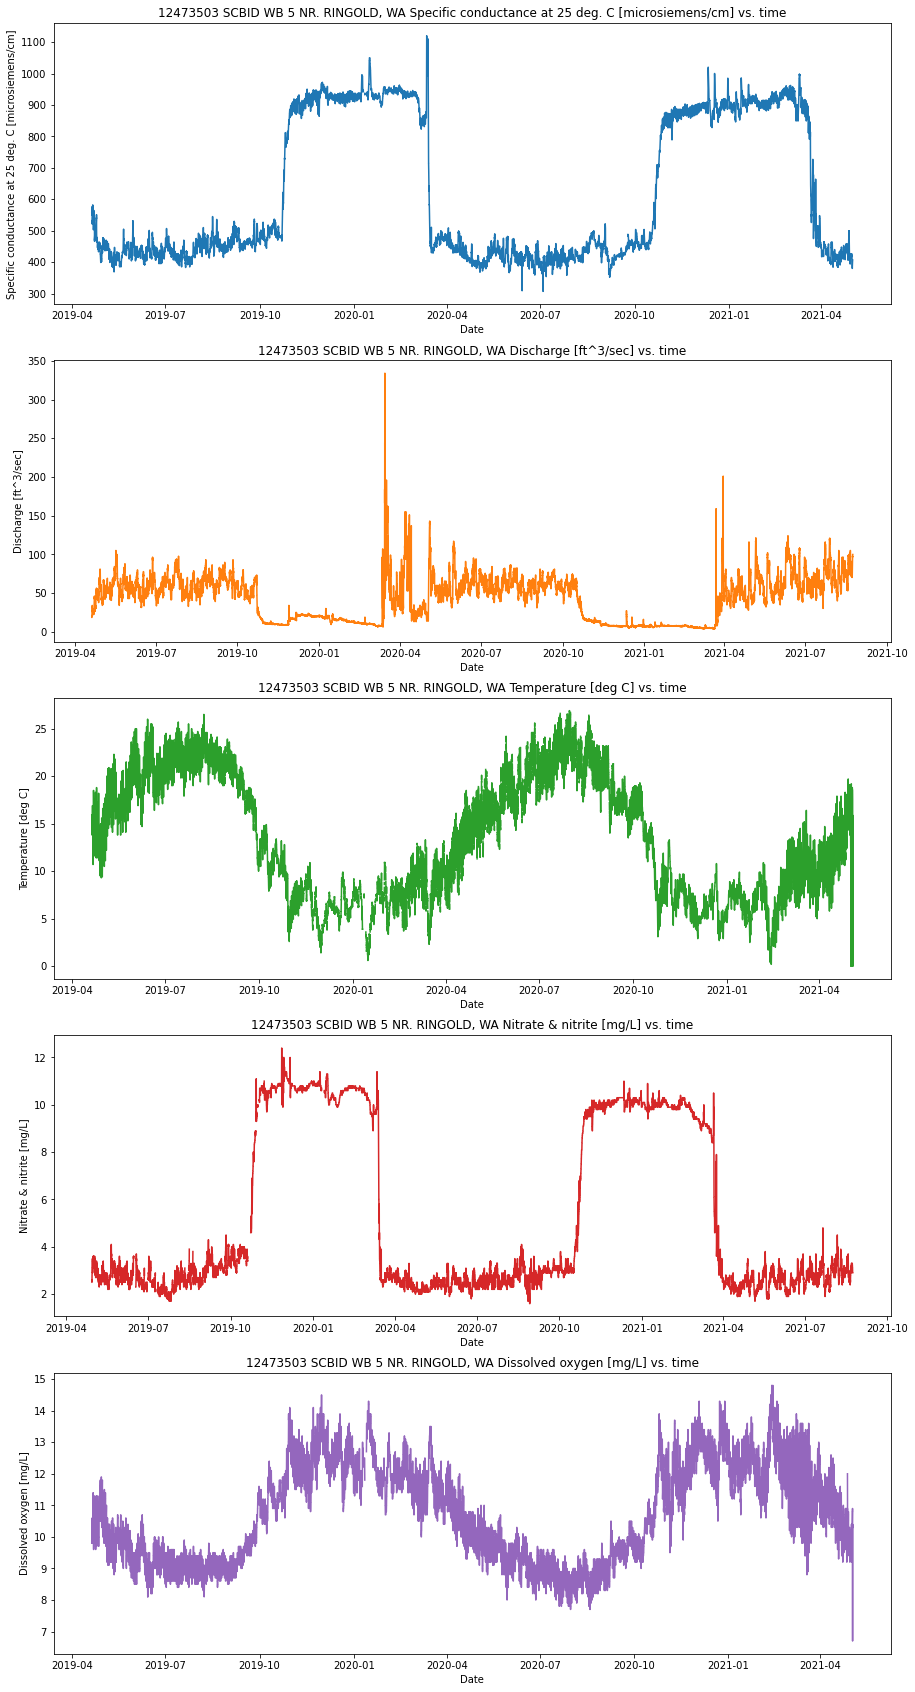

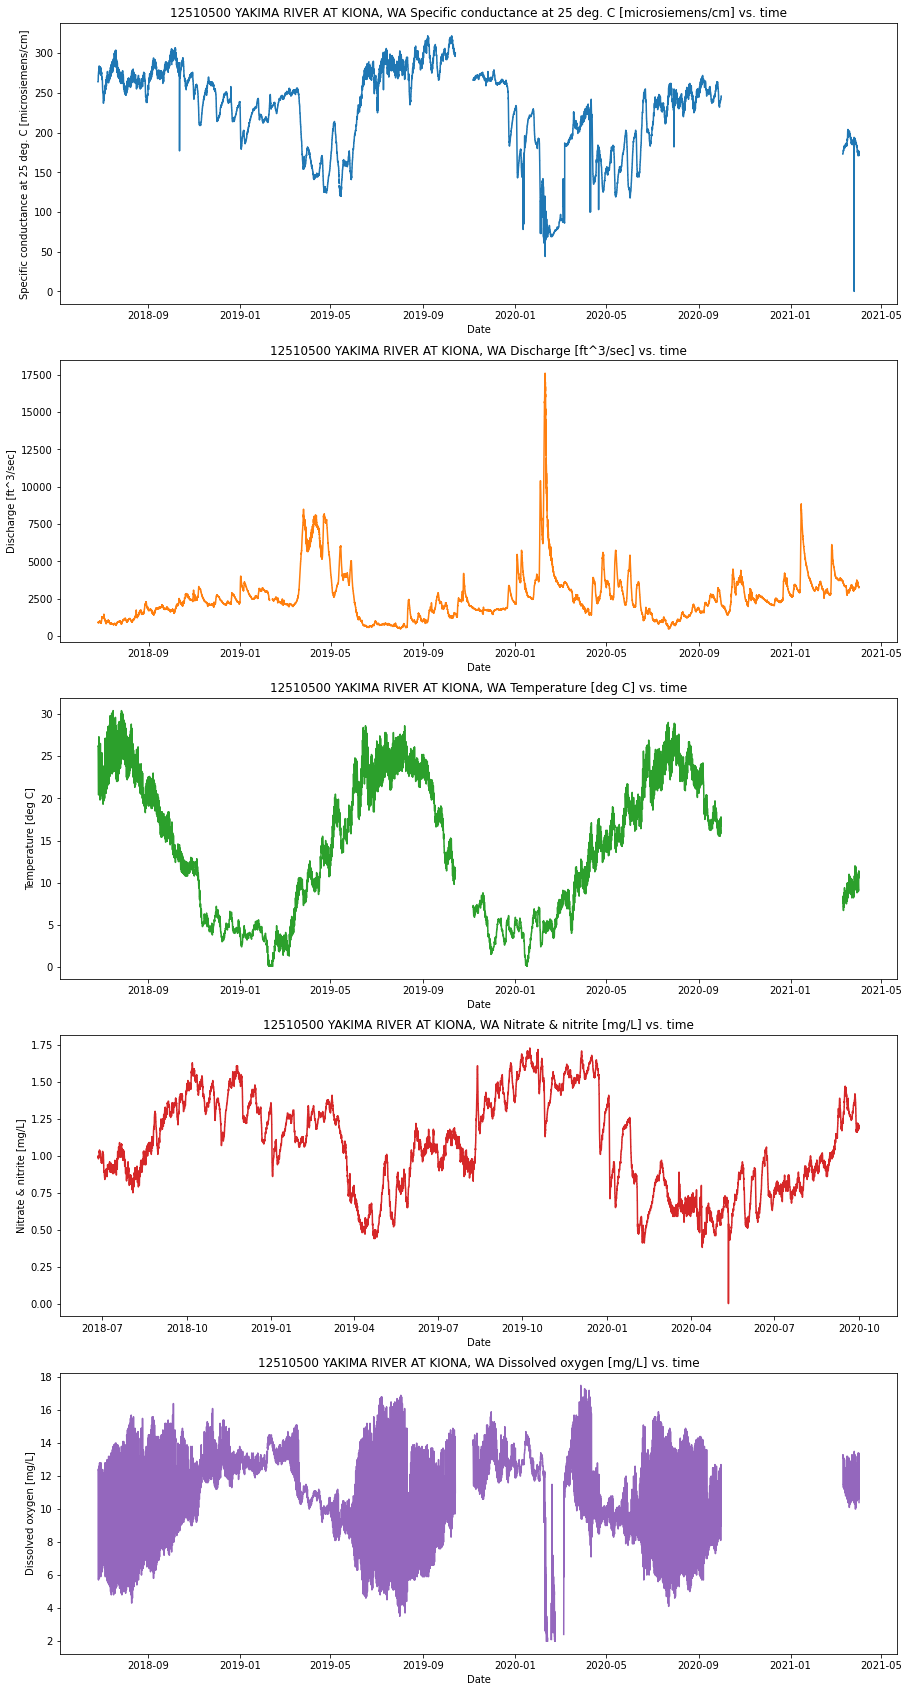

In [8]:
ringold_iv = modifyNWISdf(raw_ringold_iv)
ringold_plots = plotNWISdf(ringold_iv, "12473503 SCBID WB 5 NR. RINGOLD, WA")

kiona_iv = modifyNWISdf(raw_kiona_iv)
kiona_plots = plotNWISdf(kiona_iv, "12510500 YAKIMA RIVER AT KIONA, WA")

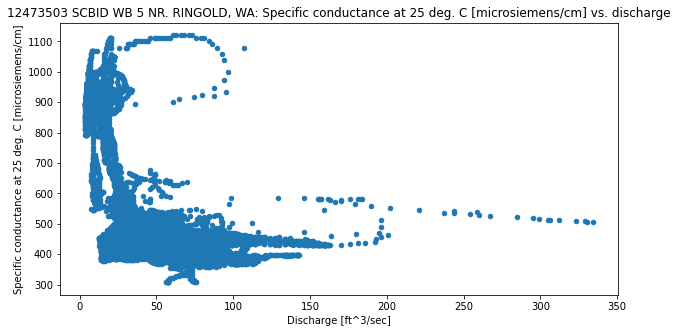

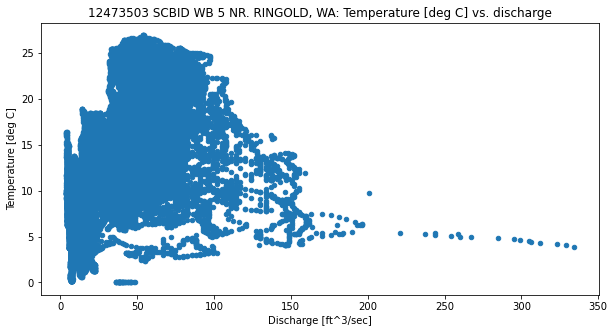

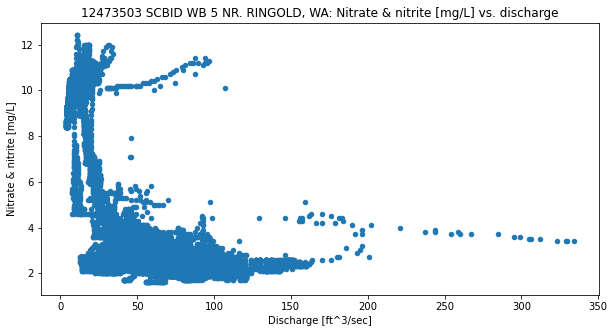

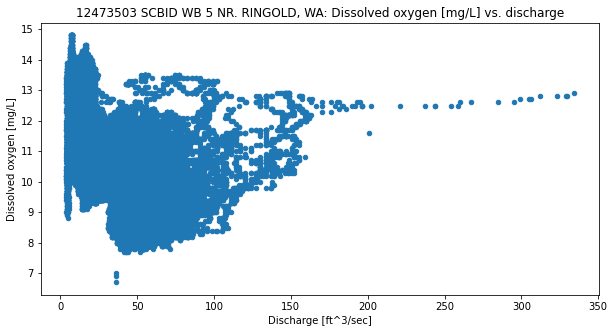

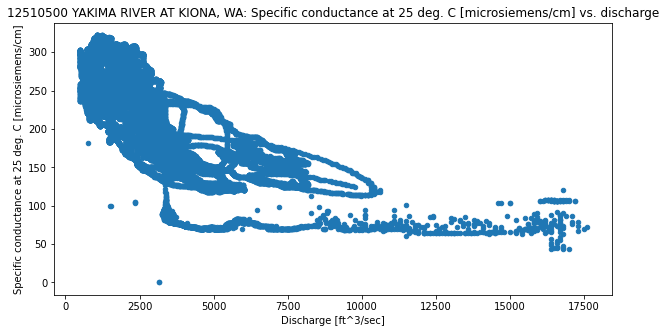

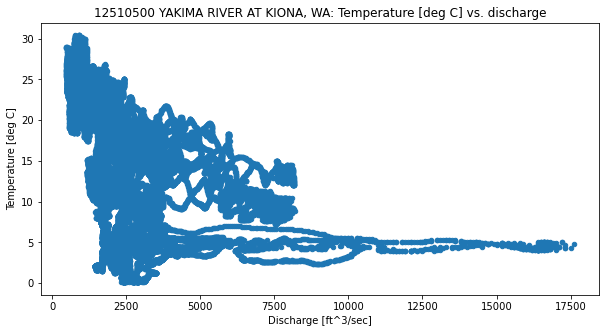

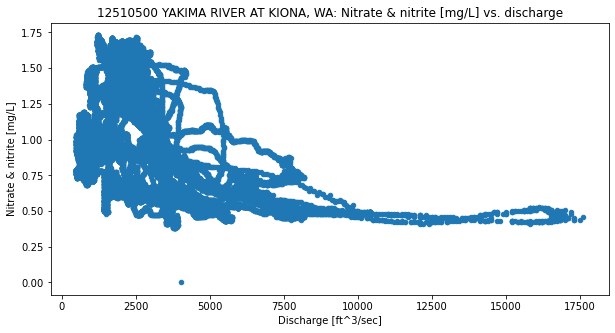

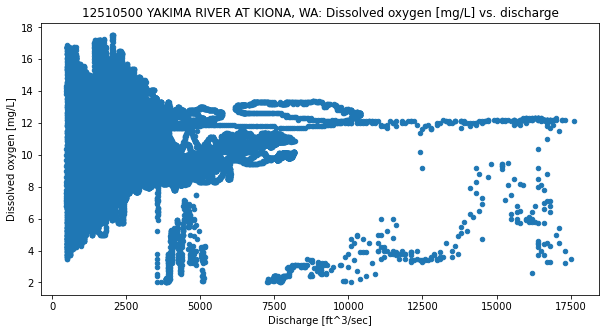

In [9]:
def plotCQ(df, stationName):
    for column in df:
        if column != "Discharge [ft^3/sec]":
            plot = df.plot(x="Discharge [ft^3/sec]", y=column, kind='scatter', figsize=(10,5))
            plot.set_title(stationName + ": " + column + " vs. discharge")

plotCQ(ringold_iv, "12473503 SCBID WB 5 NR. RINGOLD, WA")
plotCQ(kiona_iv, "12510500 YAKIMA RIVER AT KIONA, WA")

In [10]:
m = Map(center=(47,-120), zoom=7)

m.add_layer(Marker(title='SCBID WB 5 WASTEWAY NEAR MOUTH NEAR RINGOLD,WA',location=(46.536522,-119.280069),rise_on_hover = True, draggable = False))
m.add_layer(Marker(title='YAKIMA RIVER AT KIONA, WA',location = (46.253467,-119.478079),rise_on_hover = True, draggable = False))
m.add_layer(Marker(title='NOAA STATION - ICE HARBOR DAM',location = (46.2447,-118.8786),rise_on_hover = True, draggable = False))

basemap1 = basemap_to_tiles(basemaps.Esri.WorldImagery)
m.add_layer(basemap1)

display(m)

Map(center=[47, -120], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Machine Learning Models

In [31]:
kdf = kiona_iv.dropna()
rdf = ringold_iv.dropna()

kdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74479 entries, 2018-06-26 16:30:00-07:00 to 2020-10-01 00:45:00-07:00
Data columns (total 5 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Specific conductance at 25 deg. C [microsiemens/cm]  74479 non-null  float64
 1   Discharge [ft^3/sec]                                 74479 non-null  float64
 2   Temperature [deg C]                                  74479 non-null  float64
 3   Nitrate & nitrite [mg/L]                             74479 non-null  float64
 4   Dissolved oxygen [mg/L]                              74479 non-null  float64
dtypes: float64(5)
memory usage: 3.4+ MB


In [32]:
x_data = kdf.loc[:, ["Specific conductance at 25 deg. C [microsiemens/cm]",
"Discharge [ft^3/sec]",
"Temperature [deg C]"]]

y_data = kdf.loc[:, ["Dissolved oxygen [mg/L]"]]

In [33]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5)

In [34]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
norm_x_train = x_scaler.fit_transform(x_train)

norm_x_val = x_scaler.transform(x_val)
norm_x_test = x_scaler.transform(x_test)

y_scaler = StandardScaler()
norm_y_train = y_scaler.fit_transform(y_train)

norm_y_val = y_scaler.transform(y_val)
norm_y_test = y_scaler.transform(y_test)

In [35]:
def train(model, x, y, x_val, y_val, lr, epochs):
    optimizer = tf.optimizers.Adam(learning_rate=lr)
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mean_squared_error"]
    )
    
    return model.fit(
        x, 
        y,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=1
    )

In [36]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(3,)))

    hp_units = hp.Int('units', min_value=4, max_value=32, step=4)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mean_squared_error'])   

    return model

In [37]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_squared_error',
                     max_epochs=50,
                     factor=3,
                     directory='hyperparameter_tuning')

INFO:tensorflow:Reloading Oracle from existing project hyperparameter_tuning\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from hyperparameter_tuning\untitled_project\tuner0.json


In [38]:
tuner.search(norm_x_train, norm_y_train, validation_data=(norm_x_val, norm_y_val), epochs=50)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal # nodes: {best_hps.get('units')}, optimal lr: {best_hps.get('learning_rate')}")

Trial 5 Complete [00h 00m 08s]
val_mean_squared_error: 3928.57958984375

Best val_mean_squared_error So Far: 0.5550658702850342
Total elapsed time: 00h 00m 48s
INFO:tensorflow:Oracle triggered exit
Optimal # nodes: 24, optimal lr: 0.01


In [40]:
simple_model = tuner.hypermodel.build(best_hps)
simple_history = train(hypermodel, norm_x_train, norm_y_train, norm_x_val, norm_y_val, 0.01, 20)

Epoch 1/20
1862/1862 [==============================] - 3s 2ms/step - loss: 0.5362 - mean_squared_error: 0.5362 - val_loss: 0.5331 - val_mean_squared_error: 0.5331
Epoch 2/20
1862/1862 [==============================] - 4s 2ms/step - loss: 0.5370 - mean_squared_error: 0.5370 - val_loss: 0.5253 - val_mean_squared_error: 0.5253
Epoch 3/20
1862/1862 [==============================] - 3s 2ms/step - loss: 0.5365 - mean_squared_error: 0.5365 - val_loss: 0.5358 - val_mean_squared_error: 0.5358
Epoch 4/20
1862/1862 [==============================] - 6s 3ms/step - loss: 0.5349 - mean_squared_error: 0.5349 - val_loss: 0.5274 - val_mean_squared_error: 0.5274
Epoch 5/20
1862/1862 [==============================] - 5s 3ms/step - loss: 0.5366 - mean_squared_error: 0.5366 - val_loss: 0.5408 - val_mean_squared_error: 0.5408
Epoch 6/20
1862/1862 [==============================] - 5s 3ms/step - loss: 0.5370 - mean_squared_error: 0.5370 - val_loss: 0.5297 - val_mean_squared_error: 0.5297
Epoch 7/20
1862/

In [41]:
simple_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


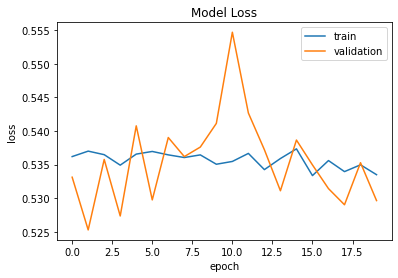

In [42]:
plt.plot(simple_history.history['loss'])
plt.plot(simple_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

,Dissolved oxygen [mg/L]
datetime,
2019-08-18 12:15:00-07:00,11.4
2018-07-19 21:15:00-07:00,8.0
2019-05-26 17:15:00-07:00,9.7
2019-08-17 03:45:00-07:00,6.3
2019-04-04 23:15:00-07:00,10.2
...,...
2018-12-08 19:00:00-08:00,13.6
2019-05-10 20:00:00-07:00,9.7
2020-08-22 08:15:00-07:00,5.9


array([[10.742898],
       [10.757276],
       [10.649704],
       ...,
       [10.672333],
       [10.79978 ],
       [10.869751]], dtype=float32)

Text(0.5, 1.0, '12510500 YAKIMA RIVER AT KIONA, WA: Predicted vs. actual DO')

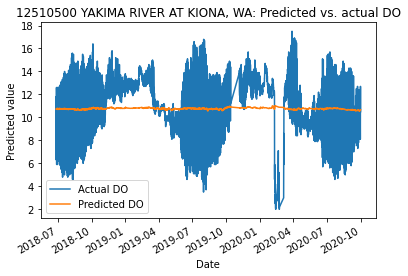

In [43]:
predict_test = simple_model.predict(norm_x_test)
predict_values = y_scaler.inverse_transform(predict_test)

final_df = copy.deepcopy(y_test)

display(final_df)
display(predict_values)

final_df[['Dissolved oxygen [mg/L]']] = predict_values

final_df.rename(columns = {'Nitrate & nitrite [mg/L]':'Predicted NO3 + NO2',
                           'Dissolved oxygen [mg/L]':'Predicted DO'                        
                          }, inplace = True)

ax = y_test.rename(columns = {'Nitrate & nitrite [mg/L]':'Actual NO3 + NO2',
                             'Dissolved oxygen [mg/L]':'Actual DO'}).plot()

final_df.plot(ax = ax, xlabel = 'Date')
ax.set_xlabel('Date')
ax.set_ylabel('Predicted value')
ax.set_title("12510500 YAKIMA RIVER AT KIONA, WA: Predicted vs. actual DO")

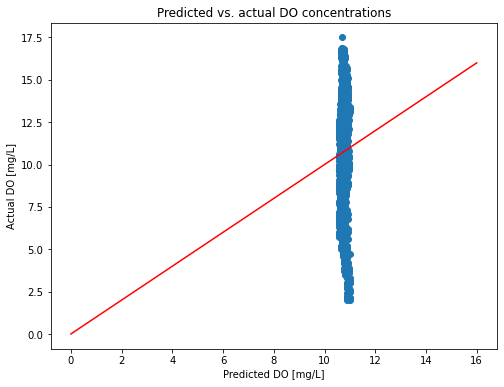

In [44]:
from matplotlib.pyplot import figure
figure(figsize=(8,6))

matplotlib.pyplot.scatter(predict_values,y_test)

plt.xlabel('Predicted DO [mg/L]')
plt.ylabel("Actual DO [mg/L]")
plt.title('Predicted vs. actual DO concentrations')

x = np.linspace(0,16,16)
y=x
plt.plot(x,y, color='#FF0000')

In [45]:
simple_model.save('simple_model2_3layer_6node.h5')

In [46]:
sklearn.metrics.r2_score(y_test,predict_values)

0.00955829999404878

In [205]:
rnn_model = keras.Sequential()
rnn_model.add()

- simple hyperparameter search (leaky relu, dropout, #node, epochs, and lr)

- run 10 models on different seeds & avg.
- model.plot()
- training val and test plots + save to file
- lstm (correct input shape)